In [7]:
import eeg_decoder
import numpy as np
import mord
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
experiment_name = 'C01c'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])

In [66]:
time_window = 50
time_step = 50
trial_bin_size = 20
n_splits = 30
group_dict = OrderedDict([('1',[1]),('2',[2])])
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [11]:
from pathlib import Path

In [19]:
sub_models = list(Path('models').glob('*'))

In [67]:
acc = np.empty((len(sub_models),exp.nsub,np.size(wrangl.t),wrangl.n_splits))
acc_shuff= np.empty((len(sub_models),exp.nsub,np.size(wrangl.t),wrangl.n_splits))

for imodel,sub_model in enumerate(sub_models):
    print(imodel)
    timepoint_models = list(sub_model.glob('*'))

    for isub in range(exp.nsub):

        xdata,ydata = exp.load_eeg(isub)
        xdata,ydata = wrangl.group_labels(xdata,ydata)

        for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

            X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
            y_test_shuffle = np.random.permutation(y_test)

            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

                clf_f = sub_model / f'{sub_model.parts[1]}_{wrangl.itime}.pkl'

                with open(clf_f, 'rb') as f:
                    clf = pickle.load(f)


                X_train, X_test = clfr.standardize(X_train, X_test)

                acc[imodel,isub, wrangl.itime, wrangl.ifold] = clf.score(X_test, y_test)
                acc_shuff[imodel,isub, wrangl.itime, wrangl.ifold] = clf.score(
                    X_test, y_test_shuffle)

                clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [58]:
import matplotlib.pyplot as plt
acc_means = np.mean(np.mean(acc,3),1),0)


In [68]:
np.argmax(np.mean(np.mean(np.mean(acc,3),1)[:,wrangl.t>200],1))

8

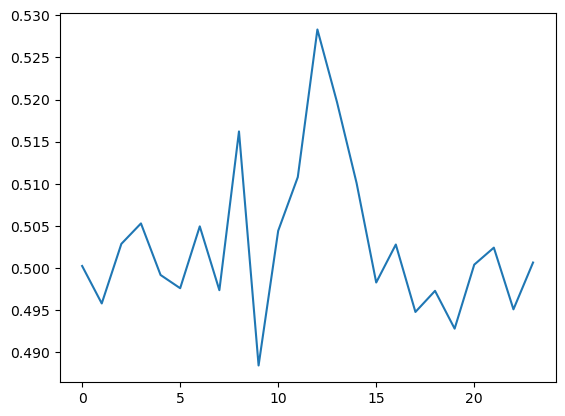

In [71]:
plt.plot(np.mean(np.mean(np.mean(acc,3),1),0));
plt.show()

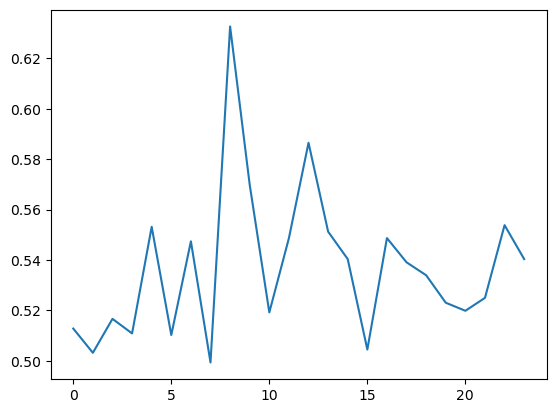

In [72]:
plt.plot(np.mean(np.mean(acc,3),1)[8]);
plt.show()


In [128]:
interp = eeg_decoder.Interpreter(clfr, subtitle='1Hv1L') 
interpbad = eeg_decoder.Interpreter(clfr, subtitle='1Hv1L') 
# interp.save_results()

In [121]:
interpbad.acc = interp.acc[[1,3,5,9,10,11,12]]
interp.acc = interp.acc[[0,2,4,6,7,8]]

In [133]:
interp.acc = interp.acc[:,:,:30]
interp.acc_shuff = interp.acc_shuff[:,:,:30]

No handles with labels found to put in legend.


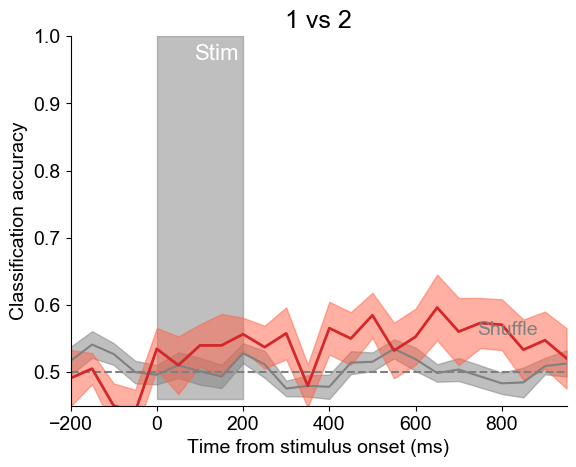

Mean delay accuracy: 0.5506837606837607
Mean delay S.D.: 0.027440556624382485


In [135]:
interp.plot_acc(significance_testing=False,savefig=False,ylim=[.45,1],chance_text_y=.23, title='1 vs 2',stim_time=[0,200])

No handles with labels found to put in legend.


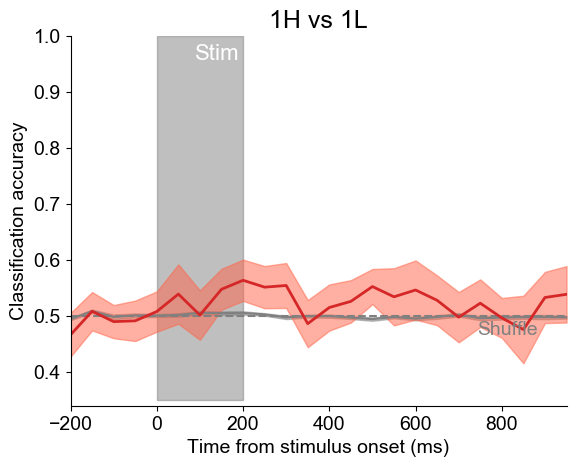

Mean delay accuracy: 0.5242047619047618
Mean delay S.D.: 0.0240572993246052


In [125]:
interpbad.plot_acc(significance_testing=False,savefig=False,ylim=[.34,1],chance_text_y=.23, title='1H vs 1L',stim_time=[0,200])

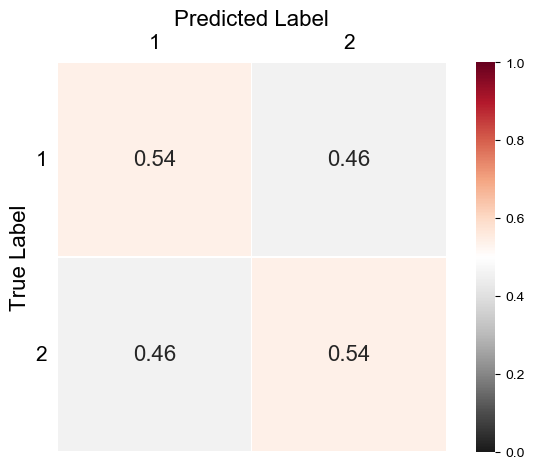

In [126]:
interp.plot_confusion_matrix()

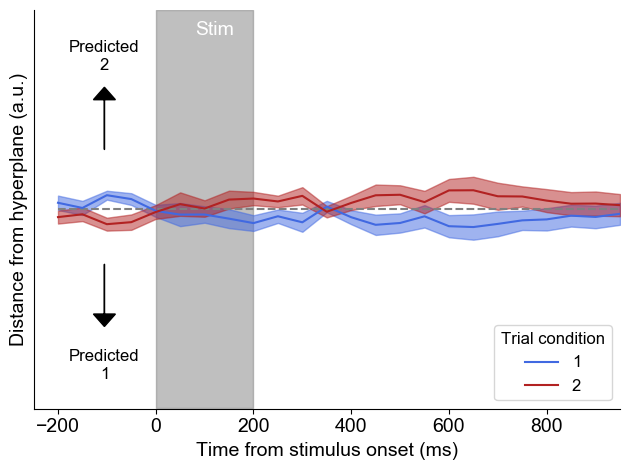

In [127]:
interp.plot_hyperplane(stim_time=[0,200], ylim=[-4,4])